# **1. Environment Set Up and Data Loading**


In [ ]:
!pip install gdown

In [ ]:
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# Google Drive URLs for the .npy files
url_categ = "https://drive.google.com/uc?id=1UiZliu_AQdlkjRhVf61Cc0_iJNvIbSyJ"
url_train = "https://drive.google.com/uc?id=1hIkzsOiDMX5B7pwxyJkiOEBV1nW6_cOB"
url_valid = "https://drive.google.com/uc?id=1nV6ugTmqf--NTzBZCpb80PO0YZmsjigs"

# Function to download and load a .npy file
def download_and_load_npy(url):
    output_file = gdown.download(url, quiet=True)
    return np.load(output_file)

# Downloading and reading the .npy files
categories = download_and_load_npy(url_categ)
training_dataset = download_and_load_npy(url_train)
valid_periods = download_and_load_npy(url_valid)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# **2. Data Exploration and Preprocessing**

> Data is loaded into Pandas DataFrames for ease of manipulation. The script
attempts to address missing values in the training dataset using a sliding window mean approach. It establishes a time series DataFrame and conducts basic data exploration.

In [ ]:
categ_df = pd.DataFrame(categories)#.T
train_df = pd.DataFrame(training_dataset)#.T
val_df = pd.DataFrame(valid_periods)

In [ ]:
seed = 72
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.0


In [ ]:
cdf = pd.DataFrame(categories)
tdf = pd.DataFrame(training_dataset)
vdf = pd.DataFrame(valid_periods)
# Rename the columns of our vdf dataframe to Start (the time instance at which the time series starts) and End (time at which it ends)
vdf = vdf.rename(columns={0: "Start", 1: "End"})

In [ ]:
tdf = tdf.replace(0, np.nan)

In [ ]:
tdf.shape

(48000, 2776)

In [ ]:
tdf.isnull().sum()

0       47999
1       47999
2       47999
3       47999
4       47999
        ...  
2771      221
2772      253
2773      513
2774      394
2775      386
Length: 2776, dtype: int64

In [ ]:
window_size = 5

# Create a copy of the original DataFrame to preserve the original data
tdf_filled = tdf.copy()

# Iterate through the rows (axis=0) and fill missing values using a sliding window mean
for i in range(len(tdf_filled)):
    window = tdf_filled.iloc[i].rolling(window=window_size, min_periods=1)

    # Calculate the mean within the sliding window
    window_mean = window.mean()

    # Fill missing values with the calculated mean
    tdf_filled.iloc[i] = tdf_filled.iloc[i].fillna(window_mean)

tdf_filled

,0,1,2,3,4,5,6,7,8,9,...,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.478704,0.412963,0.501852,0.756481,0.744444,0.640741,0.516667,0.602778,0.367593,0.331481
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.628000,0.624000,0.644000,0.688000,0.740000,0.640000,0.536000,0.600000,0.460000,0.396000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.959741,0.949098,0.919297,0.916705,0.901249,0.932531,0.955206,0.960481,0.946506,0.977140
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.411765,0.307030,0.325681,0.361549,0.430416,0.486370,0.450502,0.470588,0.569584,0.571019
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.340909,0.522727,0.568182,0.772727,0.681818,0.704545,0.863636,0.727273,0.818182,0.840909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.231879,0.327495,0.146178,0.136704,0.240361,0.319784,0.447455,0.454175,0.623485,0.013329
47996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.656293,0.624932,0.521640,0.572263,0.617589,0.494914,0.504665,0.504545,0.521760,0.091133
47997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.414474,0.480263,0.513158,0.559211,0.565789,0.588816,0.625000,0.526316,0.582237,0.552632
47998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.316062,0.481865,0.554404,0.414508,0.492228,0.523316,0.445596,0.445596,0.585492,0.404145


In [ ]:
tdf_filled.shape

(48000, 2776)

In [ ]:
tdf_filled.isnull().sum()

0       47999
1       47999
2       47999
3       47999
4       47999
        ...  
2771        6
2772        4
2773        3
2774        4
2775        3
Length: 2776, dtype: int64

In [ ]:
tdf = tdf_filled

# **3. Data Scaling and Transformation**

> The script applies Robust scaling and Min-Max scaling to the data, resulting in a scaled DataFrame stored in the variable TOTAL.

In [ ]:
def build_scaled_df(df):
    # Assuming 'your_df' is your DataFrame
    indices = df.index
    columns = df.columns

    # Apply Robust Scaler
    scaler = RobustScaler(with_centering=True)
    scaled_array = scaler.fit_transform(df)

    min_max_scaler = MinMaxScaler()
    scaled_array = min_max_scaler.fit_transform(scaled_array)

    # Create a new DataFrame with original indices and columns
    scaled_df = pd.DataFrame(data=scaled_array, columns=columns, index=indices)

    return scaled_df

In [ ]:
TOTAL = build_scaled_df(tdf)

# **4. Model Building and Training**

> The code constructs an LSTM model using TensorFlow/Keras. The training dataset is split into training and testing sets, and the model is trained using mean squared error as the loss function.

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization

In [ ]:
TOTAL = TOTAL.iloc[:,2490:].copy()

In [ ]:
TOTAL.shape

(48000, 286)

In [ ]:
def threshold_df(df):
    threshold = 0.15
    missing_percentage = df.isnull().mean(axis=1)
    mask_valid_rows = missing_percentage <= threshold
    cleaned_df = df.loc[mask_valid_rows]

    return cleaned_df

In [ ]:
TOTAL = threshold_df(TOTAL)

In [ ]:
TOTAL.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)
TOTAL.interpolate(method='linear', limit_direction='backward', axis=0, inplace=True)

In [ ]:
TOTAL.shape

(17864, 286)

In [ ]:
def build_sequences(df):
    time_steps = 200
    future_steps = 9
    X, y = [], []
    for i in range(len(df)):
        for j in range(0, 51, 5):
            X.append(df.iloc[i, j:time_steps+j].values)
            y.append(df.iloc[i, time_steps+j:time_steps+future_steps+j].values)


    # Convert the lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Now y should be of the correct shape, but let's ensure by reshaping if necessary
    y = y.reshape(-1, future_steps)

    return X, y

In [ ]:
X_total, y_total = build_sequences(TOTAL)

In [ ]:
X_total.shape

(196504, 200)

In [ ]:
y_total.shape

(196504, 9)

In [ ]:
X_total = np.expand_dims(X_total, axis=2)

In [ ]:
X_total.shape

(196504, 200, 1)

In [ ]:
X_total_train, X_total_test, y_total_train, y_total_test = train_test_split(X_total, y_total, test_size=0.2, shuffle=False)

In [ ]:
X_total_train.shape

(157203, 200, 1)

In [ ]:
y_total_train.shape

(157203, 9)

In [ ]:
time_steps = 200
future_steps = 9

# Define the LSTM model
model = Sequential()
model.add(LSTM(500, return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(500))
model.add(Dense(future_steps))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MeanSquaredError'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 200, 500)          1004000   
                                                                 
 lstm_18 (LSTM)              (None, 500)               2002000   
                                                                 
 dense_4 (Dense)             (None, 9)                 4509      
                                                                 
Total params: 3010509 (11.48 MB)
Trainable params: 3010509 (11.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


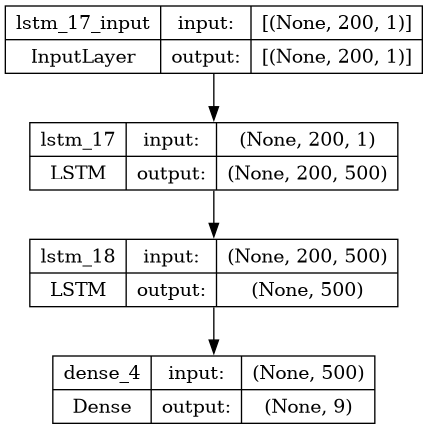

In [ ]:
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
epochs = 50
batch_size = 64

# **5. Model Evaluation and Visualization**

> The training history is captured in history_A. The script evaluates the model on the test set and generates a plot depicting a random sample of predictions against actual values. Functions are also present to visualize training/validation loss and learning rate over epochs. The trained model is saved to a file and subsequently zipped.

In [ ]:
# Train the model
history_A = model.fit(
    x = X_total_train,
    y = y_total_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_total_test, y_total_test),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=8, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/50
2457/2457 [==============================] - 201s 82ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - lr: 0.0010
Epoch 2/50
2457/2457 [==============================] - 199s 81ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - lr: 0.0010
Epoch 3/50
2457/2457 [==============================] - 199s 81ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - lr: 0.0010
Epoch 4/50
2457/2457 [==============================] - 198s 81ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - lr: 0.0010
Epoch 5/50
2457/2457 [==============================] - 198s 80ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - lr: 0.0010
Epoch 6/50
2457/2457 [==============================] - 196s 80ms/step - loss: 0.0071 - mean_squared

In [ ]:
ypred = model.predict(X_total_test)

In [ ]:
ypred.shape

In [ ]:
# Define the plotting function
def plot_random(x, y, y_pred):
    plt.figure(figsize=(12, 6))

    # Randomly select one of the test samples
    index = random.randint(0, x.shape[0] - 1)

    # Define the range for the time series and future values
    time_series_range = range(time_steps - future_steps, time_steps)
    future_values_range = range(time_steps, time_steps + future_steps)

    # Plot the end of the time series data
    plt.plot(time_series_range, x[index][-future_steps:].flatten(), label='Time Series')
    # Plot the actual future values
    plt.plot(future_values_range, y[index], label='Actual Values', marker='o', linestyle='dashed')
    # Plot the predicted future values
    plt.plot(future_values_range, y_pred[index], label="Predicted Values", marker='o', linestyle='dashed')

    # Add title and labels
    plt.title('Time Series Plot of Selected Rows')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Plotting a random sample from the test set
plot_random(X_total_test, y_total_test, ypred)

In [ ]:
def plot_epochs(history):
    best_epoch = np.argmin(history['val_loss'])
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Mean Squared Error')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(18,3))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

In [ ]:
plot_epochs(history_A)

In [ ]:
model.save("model_TOTAL_2")

In [ ]:
!zip -r model_total.zip /kaggle/working/model_TOTAL